100%|██████████| 9.91M/9.91M [00:00<00:00, 54.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.96MB/s]


Epoch [1/10], Train Loss: 0.3456, Test Loss: 0.1730, Accuracy: 94.65%
Epoch [2/10], Train Loss: 0.1506, Test Loss: 0.1156, Accuracy: 96.31%
Epoch [3/10], Train Loss: 0.1132, Test Loss: 0.1065, Accuracy: 96.49%
Epoch [4/10], Train Loss: 0.0920, Test Loss: 0.0927, Accuracy: 97.07%
Epoch [5/10], Train Loss: 0.0784, Test Loss: 0.0935, Accuracy: 97.19%
Epoch [6/10], Train Loss: 0.0681, Test Loss: 0.0870, Accuracy: 97.22%
Epoch [7/10], Train Loss: 0.0587, Test Loss: 0.0906, Accuracy: 97.37%
Epoch [8/10], Train Loss: 0.0533, Test Loss: 0.0743, Accuracy: 97.49%
Epoch [9/10], Train Loss: 0.0480, Test Loss: 0.0981, Accuracy: 96.97%
Epoch [10/10], Train Loss: 0.0432, Test Loss: 0.0989, Accuracy: 97.05%


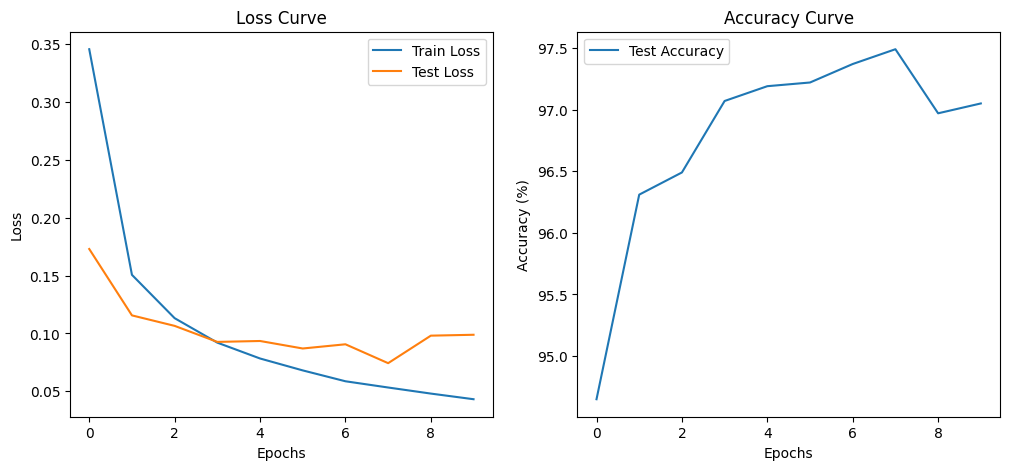

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# -----------------------------
# 1. Hyperparameters
# -----------------------------
batch_size = 64
learning_rate = 0.001
epochs = 10
hidden_layers = [256, 128]  # Tunable
activation_fn = nn.ReLU()   # Try nn.Sigmoid(), nn.Tanh(), etc.
dataset_choice = "        "    # Change to "FashionMNIST"

# -----------------------------
# 2. Load Dataset
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

if dataset_choice == "MNIST":
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
else:
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# 3. Define MLP Model
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(in_features, h))
            layers.append(activation)
            in_features = h
        layers.append(nn.Linear(in_features, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.network(x)

model = MLP(28*28, hidden_layers, 10, activation_fn)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# -----------------------------
# 4. Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -----------------------------
# 5. Training Loop
# -----------------------------
train_losses, test_losses, accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # -----------------------------
    # 6. Evaluate on Test Set
    # -----------------------------
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

# -----------------------------
# 7. Plot Loss & Accuracy Curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.show()